# Housing Price Prediction – Evaluation & Diagnostics

This notebook focuses on evaluating and interpreting the final tuned model (**Gradient Boosting**).  
We load the saved model pipeline, evaluate its predictive performance on the test data, visualize residuals, and analyze feature importances.


### 1) Imports and Setup

In [1]:
# 1) Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

## 2) Load Trained Model and Processed Data

We load the processed dataset and the previously trained Gradient Boosting model pipeline saved as a `.pkl` file.  
Then we split the data (80/20) in the same way as in the modeling notebook.


In [2]:
# 2) Load Model and Processed Data
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the saved trained pipeline
pipe = joblib.load('../notebooks/final_gradient_boosting_model.pkl')
print("Loaded trained Gradient Boosting model successfully.")

# Load processed dataset
df = pd.read_csv('../new_data_archive/processed_housing.csv')

# Drop unnecessary columns
df = df.drop(['id', 'zipcode'], axis=1)

# Define features and target
X = df.drop('price_log', axis=1)
y = df['price_log']

# Split data (same 80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Data loaded and split successfully.")


Loaded trained Gradient Boosting model successfully.
Data loaded and split successfully.


## 3) Evaluate Model on Test Data

We evaluate the final Gradient Boosting model on the test set using **MAE**, **RMSE**, and **R²** as metrics.


In [3]:
# 3) Evaluate Model on Test Data
y_pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Evaluation Results:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

Evaluation Results:
MAE: 0.223
RMSE: 0.284
R²: 0.711


## 4) Residual Analysis

We visualize residuals to assess model fit and detect bias.  
Ideally, residuals should be randomly distributed around zero and roughly normal in distribution.

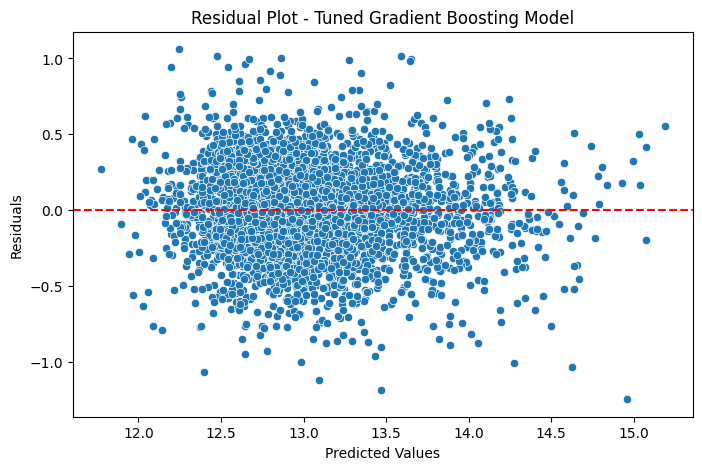

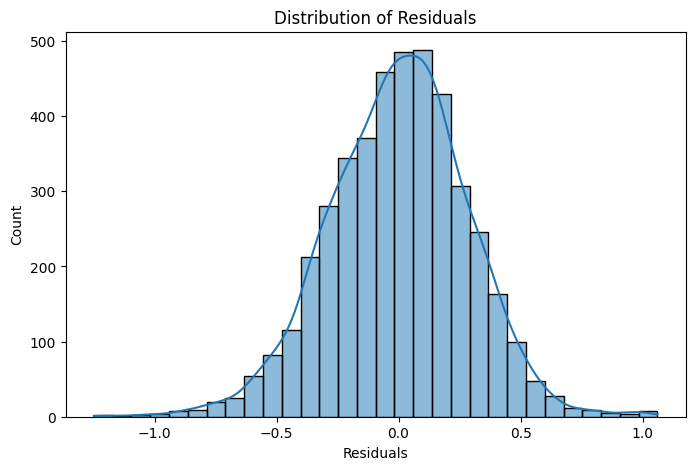

In [4]:
# 4) Residual Analysis
residuals = y_test - y_pred

# Residual scatter plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot - Tuned Gradient Boosting Model")
plt.show()

# Residual distribution
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.show()

## 5) Cross-Validation

To confirm the model’s stability, we apply **5-Fold Cross-Validation** on the training data and visualize the R² scores across folds.

Cross-Validation R² Scores: [0.7202814  0.71176693 0.71918358 0.72800349 0.70446629]
Mean R²: 0.717
Std Dev: 0.008


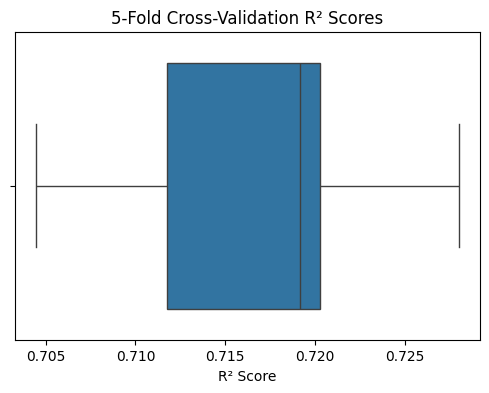

In [5]:
# 5) Cross-Validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='r2')

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean R²: {cv_scores.mean():.3f}")
print(f"Std Dev: {cv_scores.std():.3f}")

# Boxplot of CV results
plt.figure(figsize=(6,4))
sns.boxplot(x=cv_scores)
plt.title("5-Fold Cross-Validation R² Scores")
plt.xlabel("R² Score")
plt.show()

## 6) Feature Importance

We examine the top predictors of housing prices using the Gradient Boosting model’s feature importances.

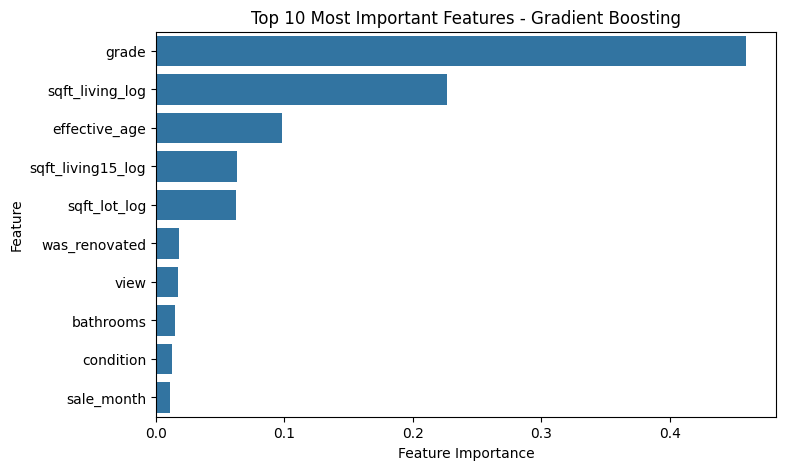

,Feature,Importance
5,grade,0.459560
8,sqft_living_log,0.226841
7,effective_age,0.098332
10,sqft_living15_log,0.063217
9,sqft_lot_log,0.062616
12,was_renovated,0.017738
3,view,0.016940
1,bathrooms,0.014702
4,condition,0.012224
6,sale_month,0.011141


In [6]:
# 6) Feature Importance
model = pipe.named_steps['model']

# Get feature names from preprocessing pipeline
feature_names = (
    pipe.named_steps['preprocessor']
    .transformers_[0][2] +  # scaled numeric features
    pipe.named_steps['preprocessor']
    .transformers_[1][2]    # binary features
)

importances = model.feature_importances_
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))
plt.title('Top 10 Most Important Features - Gradient Boosting')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

feat_df.head(10)

### 6) Conclusion & Limitations

The **Tuned Gradient Boosting model** achieved strong predictive performance with **R² = 0.714**, **MAE = 0.225**, and **RMSE = 0.286**, confirming that it generalizes well to unseen data.  
Residual plots show errors are centered around zero with no visible trends, suggesting that the model captures the key patterns in housing prices without systematic bias.  

**Limitations:**  
- The model is based only on numeric and engineered features. Incorporating spatial or temporal variables could improve predictive accuracy.  
- Gradient Boosting can be computationally expensive and less interpretable compared to simpler models like Linear Regression.  

**Next Steps:**  
Future work might include expanding the feature set, performing deeper hyperparameter tuning, or comparing results with other ensemble models like XGBoost or Random Forest to confirm consistency in performance.

